In [1]:
# Connect to goggle drive
from google.colab import drive
drive.mount("/content/drive")

# Import needed libraries 
import matplotlib.pyplot as plt
import numpy

Mounted at /content/drive


# Functions for loading and previewing spectral images

In [2]:
from PIL import Image
import os

def get_spectral_cube(dirpath):
  myDir = os.listdir(dirpath)

  # Read the first image define it size, define the total number of Images and get the size of future ENVI Spectral Cube
  fullpath = os.path.join(dirpath, myDir[0])
  im = Image.open(fullpath)
  single_slice = numpy.array(im) # make a numpy array
  [x, y] = single_slice.shape
  '''
  for i in range (300, 305, 1):
    for j in range (550, 555, 1):
      im.putpixel((i, j), 255)

  display(im)
  '''

  k = 0
  real_path = []
  for i in range (10):
    old_pixel = 0
    real_path.append("")
    for j in range (13):
      index     = (13*i) + j
      fullpath  = os.path.join(dirpath, myDir[index])
      im        = Image.open(fullpath)
      pixel     = im.getpixel((300, 550))
      
      if((pixel > 50 and pixel < 255) and (pixel > old_pixel)):
        old_pixel = pixel
        real_path[i] = fullpath
    k = k + 1

  spectral_cube = numpy.ndarray(shape=(x,10,y), dtype=numpy.uint16)
  waves = []
  for i in range (10):
    print(real_path[i])
    single_slice = numpy.array(Image.open(real_path[i]))
    spectral_cube[:,i,:] = single_slice
    waves.append(i+1)
  print(spectral_cube.shape)

  return spectral_cube, waves


In [3]:
def preview_RGB(spectral_cube, ch_1, ch_2, ch_3):
  lines, bands, samples = spectral_cube.shape
  RGB = numpy.empty((lines, samples, 3)) # Create a 'bmp' array with spatial size of ENVI 512,512 with 3 layers
  if (type(spectral_cube[0, 0, 0]) == numpy.uint16):
    RGB[:,:,0] = spectral_cube[:,ch_1,:]/numpy.amax(spectral_cube[:,ch_1,:]) # np.amax gets max value. Thus we get RGB in range [0,1]
    RGB[:,:,1] = spectral_cube[:,ch_2,:]/numpy.amax(spectral_cube[:,ch_2,:])
    RGB[:,:,2] = spectral_cube[:,ch_3,:]/numpy.amax(spectral_cube[:,ch_3,:])
  else:
    RGB[:,:,0] = spectral_cube[:,ch_1,:]
    RGB[:,:,1] = spectral_cube[:,ch_2,:]
    RGB[:,:,2] = spectral_cube[:,ch_3,:]
  plt.rcParams['figure.dpi'] = 200
  plt.imshow(RGB)
  plt.show()
  return RGB

In [4]:
def find_region_spectrum(cube, RGB, x1, x2, y1, y2):
  #Select an array
  RGB2 = RGB.copy()
  spectral_image = cube.copy()
  ##################################################################
  # Select pixels/ colour
  RGB2[y1:y2,x1:x2,0] = 0
  RGB2[y1:y2,x1:x2,1] = 1
  RGB2[y1:y2,x1:x2,2] = 0
  sel = spectral_image[y1:y2,:,x1:x2]
  sel1 = numpy.sum(sel, axis = 0)
  region = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################
  plt.rcParams['figure.dpi'] = 150
  plt.imshow(RGB2)
  plt.show()
  return region

In [5]:
def get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, waves, x1, y1, title):
  region = find_region_spectrum(spectral_cube, object_RGB, x1, x1+15, y1, y1+15)    # Selecting region  
  white_region = find_region_spectrum(white_cube, w_RGB, x1, x1+15, int(white_cube.shape[0]/2), int(white_cube.shape[0]/2) + 15)
  #white_region = find_region_spectrum(white_cube, w_RGB, int(white_cube.shape[2])-50, int(white_cube.shape[2])-35, int(white_cube.shape[0]/2), int(white_cube.shape[0]/2) + 15)

  #Plotting selected region, white and dark spectrum
  plt.plot(waves, white_region, "b")
  plt.plot(waves, region, "r")
  plt.xlabel('Wavelength, um')
  plt.ylabel(title)
  plt.show()

# Main Code

/content/drive/MyDrive/Summer School/ASI course 2021/Measurement session (for all)/Tunable light source/ImagesASI/Colorchecker/Colorchecker_channel=1_1000ms.png
/content/drive/MyDrive/Summer School/ASI course 2021/Measurement session (for all)/Tunable light source/ImagesASI/Colorchecker/Colorchecker_channel=2_250ms.png
/content/drive/MyDrive/Summer School/ASI course 2021/Measurement session (for all)/Tunable light source/ImagesASI/Colorchecker/Colorchecker_channel=3_125ms.png
/content/drive/MyDrive/Summer School/ASI course 2021/Measurement session (for all)/Tunable light source/ImagesASI/Colorchecker/Colorchecker_channel=4_500ms.png
/content/drive/MyDrive/Summer School/ASI course 2021/Measurement session (for all)/Tunable light source/ImagesASI/Colorchecker/Colorchecker_channel=5_31.3ms.png
/content/drive/MyDrive/Summer School/ASI course 2021/Measurement session (for all)/Tunable light source/ImagesASI/Colorchecker/Colorchecker_channel=6_15.6ms.png
/content/drive/MyDrive/Summer School/

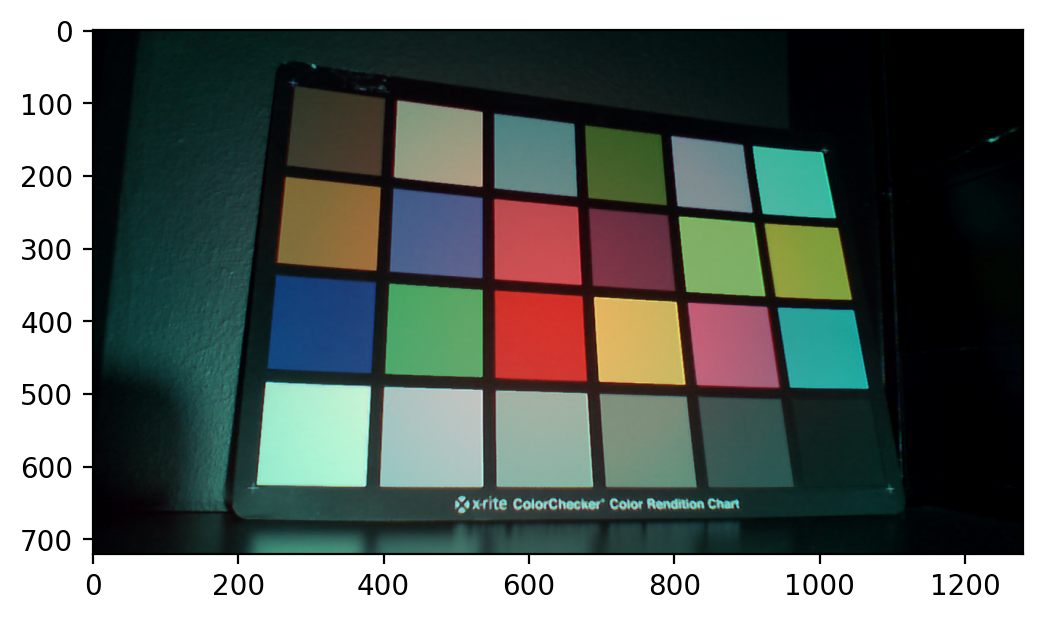

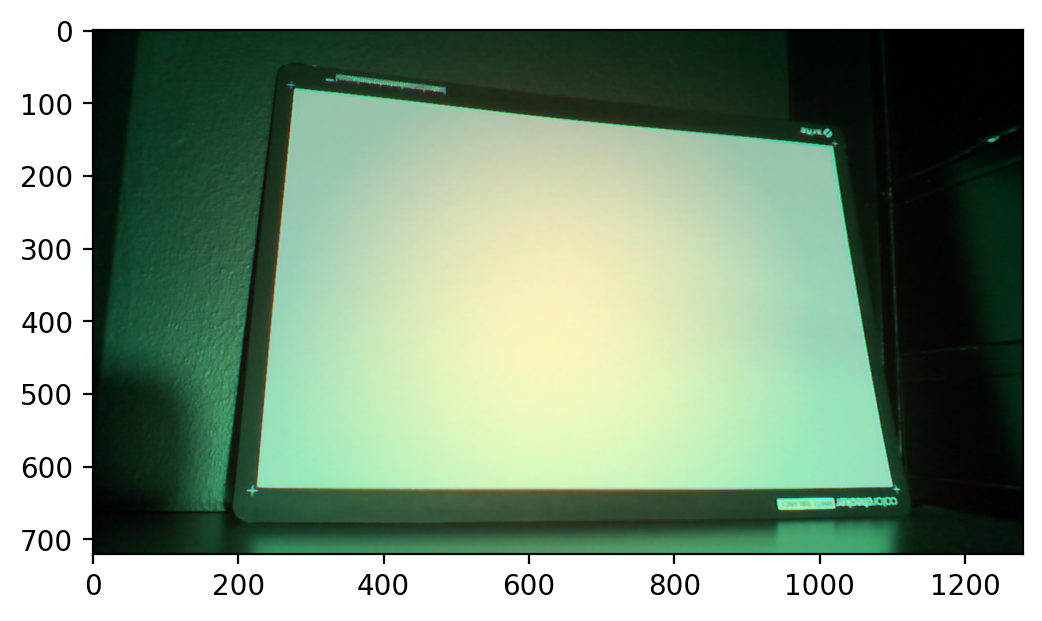

In [32]:
[ch_1, ch_2, ch_3] = [9, 5, 3]
[spectral_cube, waves]   = get_spectral_cube("/content/drive/MyDrive/Summer School/ASI course 2021/Measurement session (for all)/Tunable light source/ImagesASI/Colorchecker/")
[white_cube, w_waves]    = get_spectral_cube("/content/drive/MyDrive/Summer School/ASI course 2021/Measurement session (for all)/Tunable light source/ImagesASI/White/")
object_RGB    = preview_RGB(spectral_cube, ch_1, ch_2, ch_3)
w_RGB         = preview_RGB(white_cube, ch_1, ch_2, ch_3)


# Using Element Wise for white correction

In [12]:
def element_wise(image_data, RGB2, obj_x1, obj_y1, white_x1, white_y1, waves):
  ##################################################################
  # Select obj
  x1 = obj_x1
  x2 = obj_x1 + 10
  y1 = obj_y1
  y2 = obj_y1 + 10
  RGB2[y1:y2,x1:x2,0] = 0
  RGB2[y1:y2,x1:x2,1] = 0
  RGB2[y1:y2,x1:x2,2] = 0
  sel = image_data[y1:y2,:,x1:x2]
  sel1 = numpy.sum(sel, axis = 0)
  red = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################
  # Select White
  x1 = white_x1
  x2 = white_x1 + 10
  y1 = white_y1
  y2 = white_y1 + 10
  RGB2[y1:y2,x1:x2,0] = 0
  RGB2[y1:y2,x1:x2,1] = 0
  RGB2[y1:y2,x1:x2,2] = 0
  sel = image_data[y1:y2,:,x1:x2]
  sel1 = numpy.sum(sel, axis = 0)
  white = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))

  plt.rcParams['figure.dpi'] = 150
  plt.imshow(RGB2)
  plt.show()

  plt.plot(waves, red, "r")
  plt.plot(waves, white, "black")

  plt.xlabel('Wavelength, um')
  plt.ylabel('Camera raw data,')
  #plt.ylabel('Reflectance [0-100]%')
  plt.show()

  # Graph After White noise correction has been made by normalisation
  red_cor = red/white
  white_cor = white/white
  plt.rcParams['figure.dpi'] = 200

  plt.plot(waves, red_cor, "r")
  plt.plot(waves, white_cor, "black")
  plt.xlabel('Wavelength, um')
  plt.ylabel('Camera raw data,')
  plt.ylabel('Reflectance [0-100]%')
  plt.show()

  # Element-wise White Correction
  [lines, bands, samples] = image_data.shape
  corr = numpy.empty((lines,bands,samples), dtype = numpy.float32)

  for i in range(0,lines):
    for j in range(0,samples):
        corr[i,:,j] = image_data[i,:,j]/white
  return corr

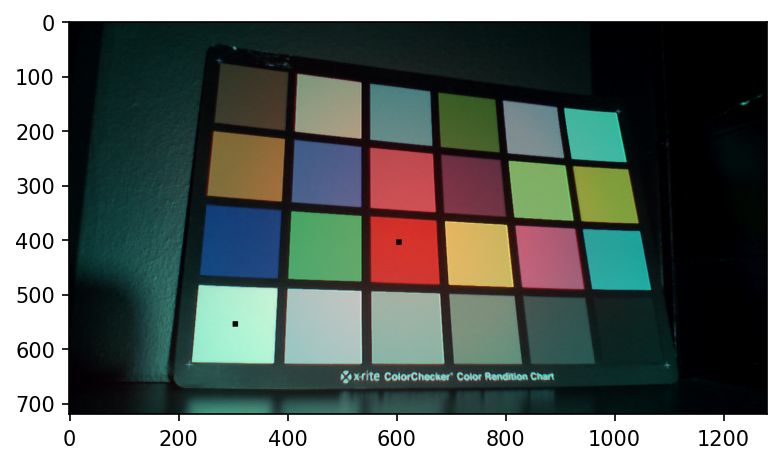

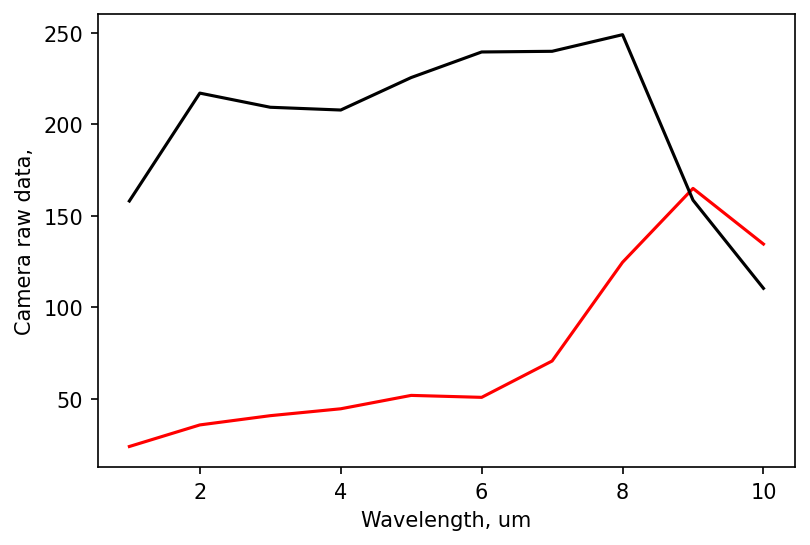

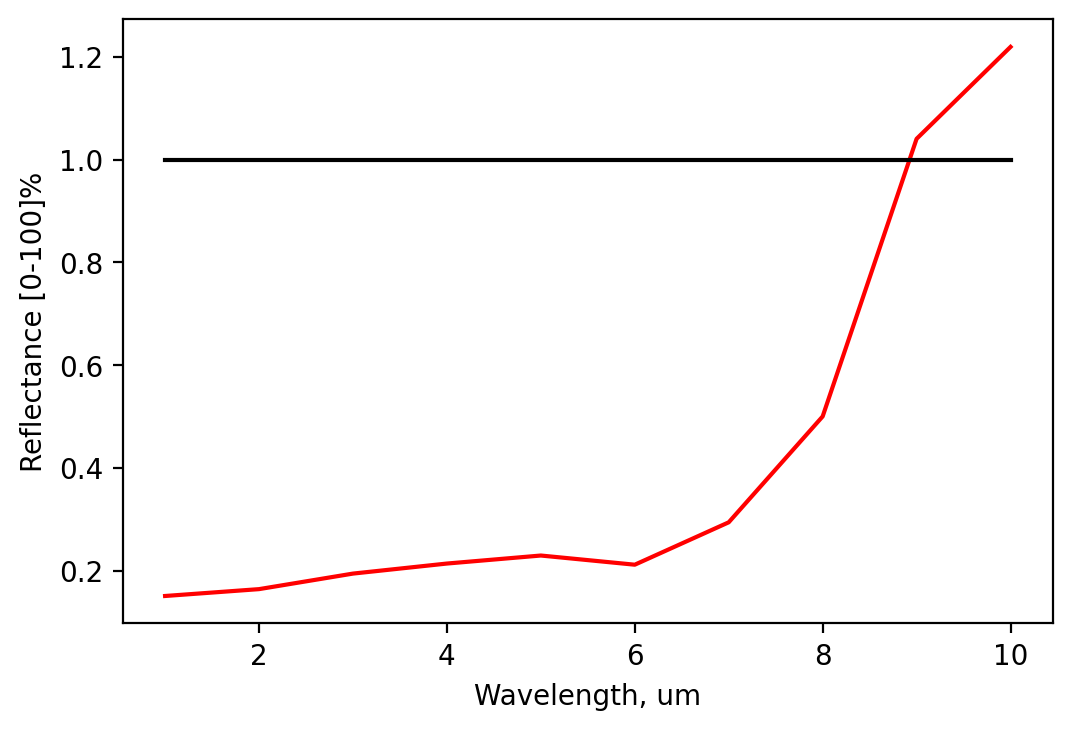

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


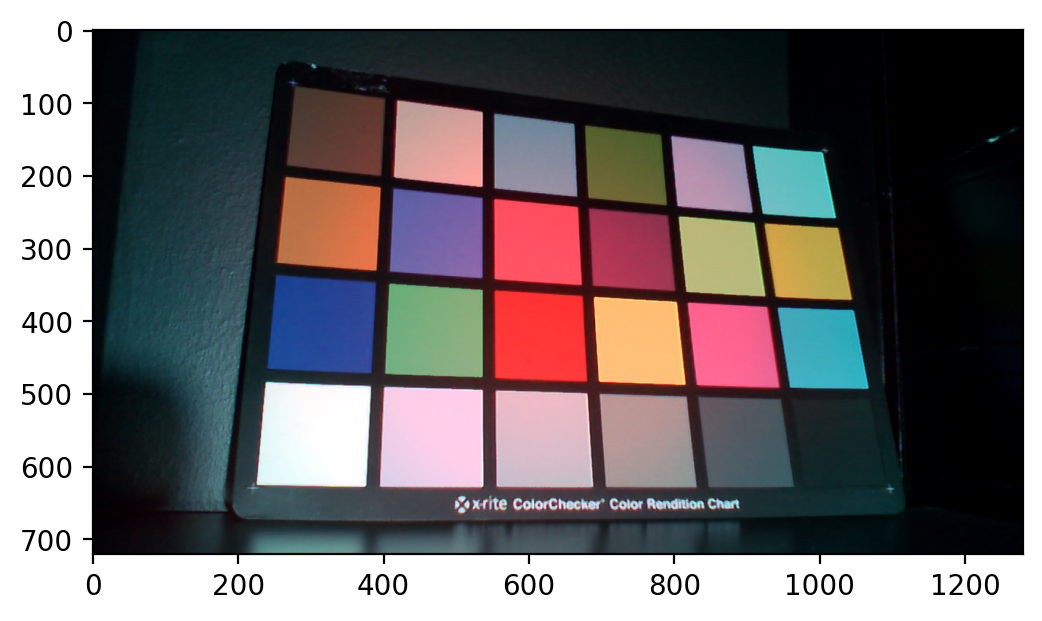

In [15]:
corr_spectral_cube = element_wise(spectral_cube, object_RGB, 600, 400, 300, 550, waves)
object_RGB = preview_RGB(corr_spectral_cube, ch_1, ch_2, ch_3)

# Using Pixel Wise for white correction

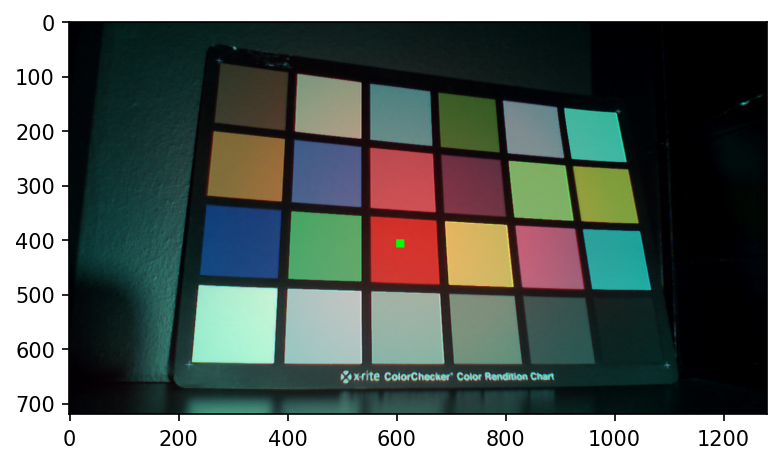

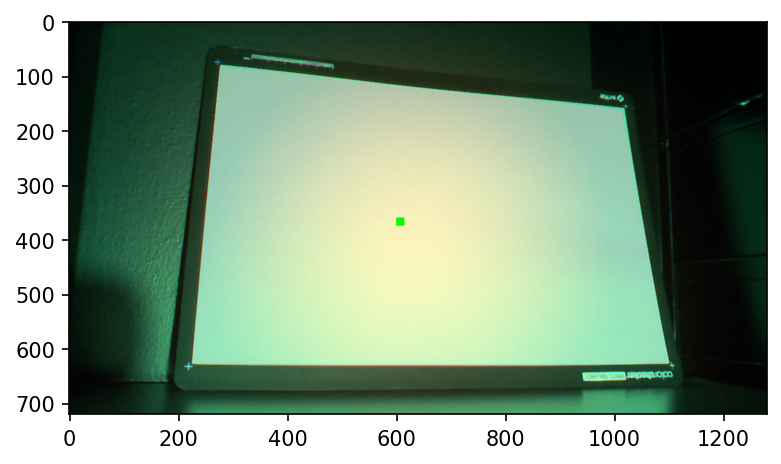

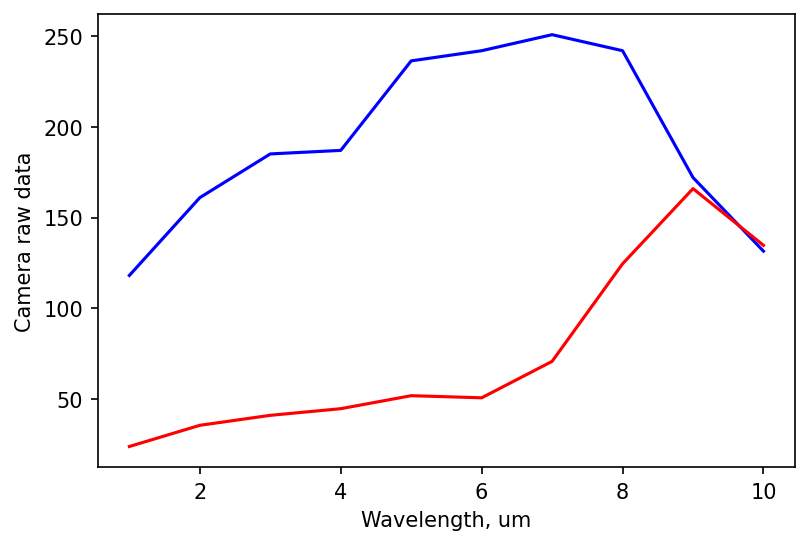

In [28]:
get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, waves, 600, 400, 'Camera raw data')

In [34]:
# White Correction - Advance method
def white_correction(spectral_cube, white_cube):
  n_spectral_cube = spectral_cube[150:600, :, 300:1000]
  n_white_cube = white_cube[150:600, :, 300:1000]
  print(n_spectral_cube.shape)
  print(n_white_cube.shape)
  cube = numpy.ndarray(n_spectral_cube.shape, dtype=numpy.float32)
  cube = numpy.divide(n_spectral_cube, n_white_cube, where=n_white_cube!=0)
  return cube, n_white_cube

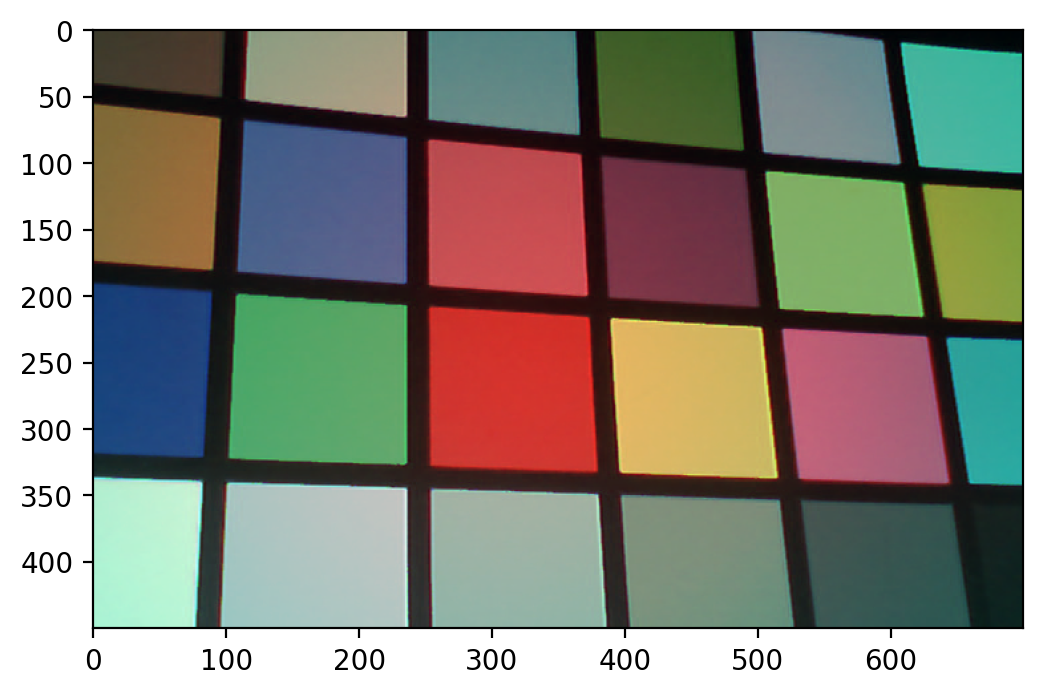

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(450, 10, 700)
(450, 10, 700)


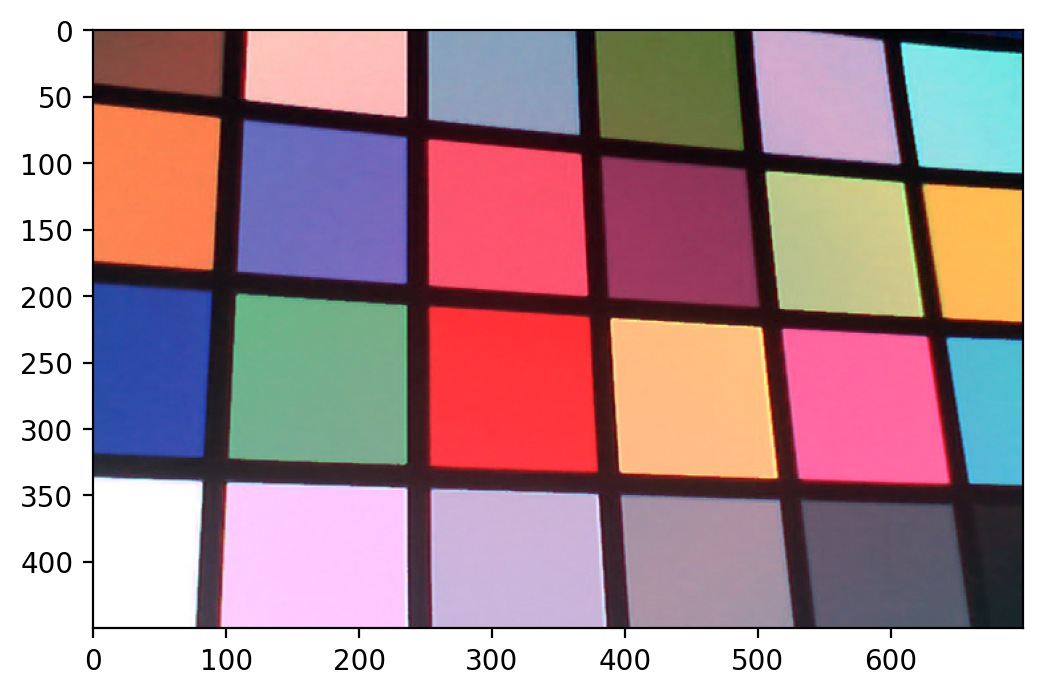

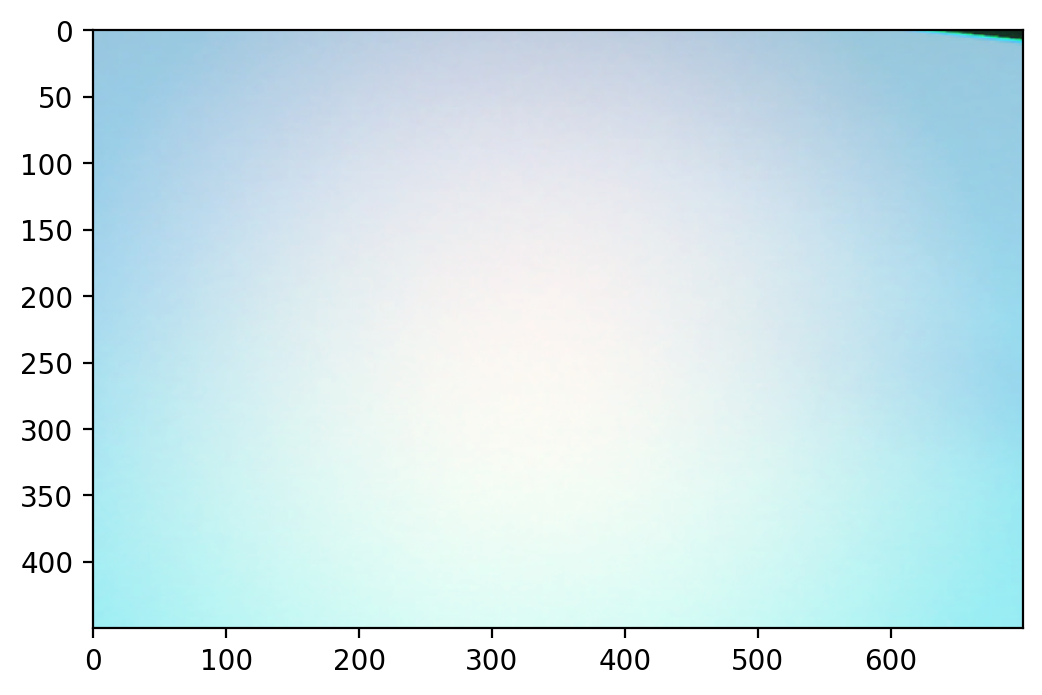

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


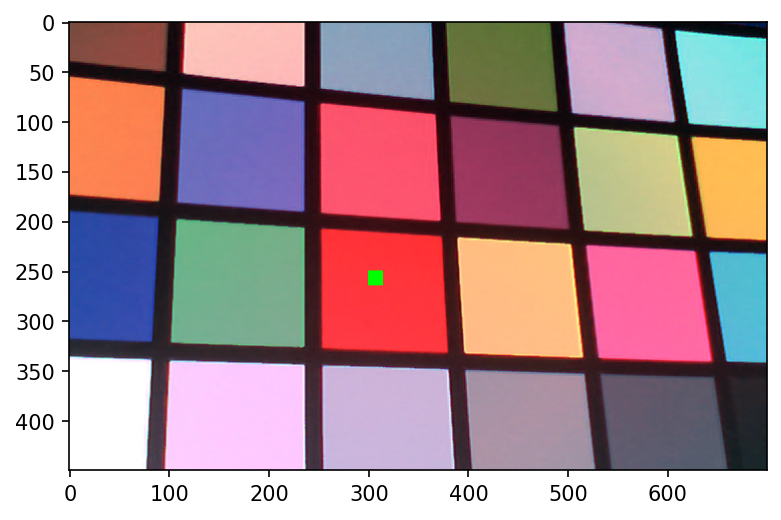

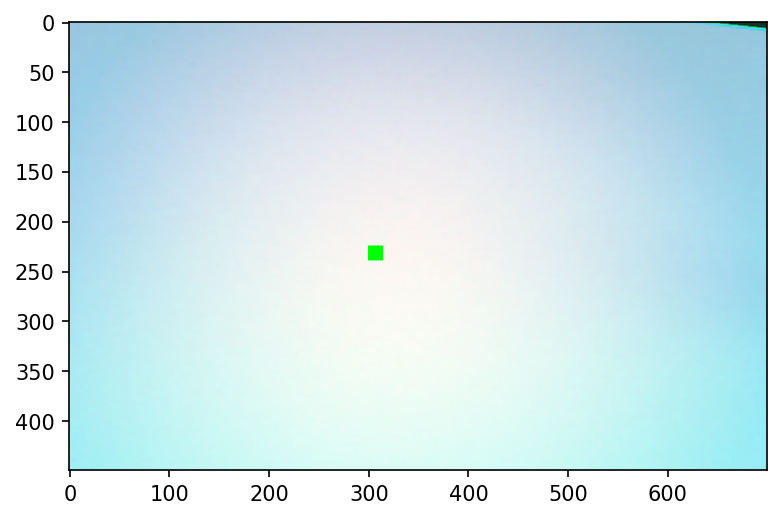

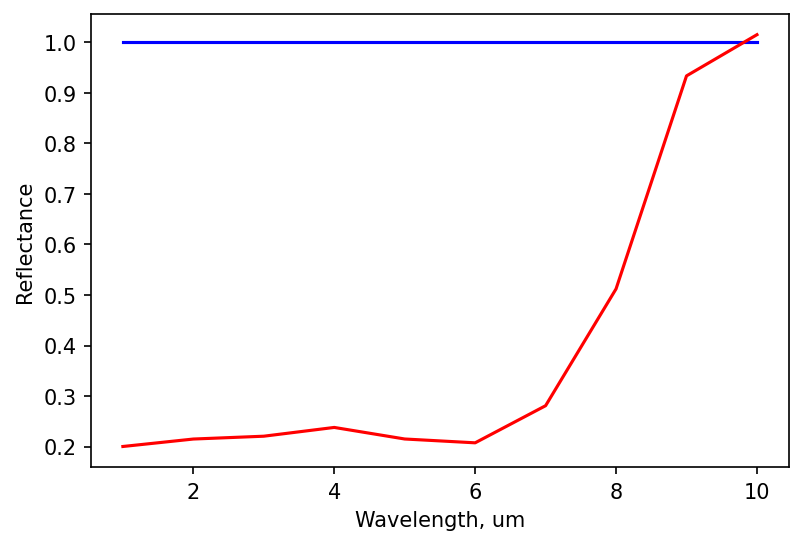

In [33]:
[corr_spectral_cube, w_cube] = white_correction(spectral_cube, white_cube)
object_RGB = preview_RGB(corr_spectral_cube, ch_1, ch_2, ch_3)
w_RGB      = preview_RGB(w_cube, ch_1, ch_2, ch_3)
get_spectra(corr_spectral_cube, object_RGB, w_cube/w_cube, w_RGB, waves, 300, 250, 'Reflectance')

# Segmentation

In [18]:
def get_region_spectra(image_data, RGB, reg_x1, reg_y1):
  RGB2 = RGB.copy()
  ##################################################################
  # Select region
  x1 = reg_x1
  x2 = x1 + 30
  y1 = reg_y1
  y2 = y1 + 30

  RGB2[x1:x2,y1:y2,0] = 0
  sel = image_data[x1:x2,:,y1:y2]

  sel1 = numpy.sum(sel, axis = 0)
  selection1 = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################

  plt.imshow(RGB2)
  plt.rcParams['figure.dpi'] = 150
  plt.show()

  plt.plot(selection1) #plt.plot(waves,selection1)
  plt.xlabel('Wavelength, nm / bands')
  plt.ylabel('Reflectance [0-100]%')
  plt.title("Average spectrum of selected area")
  plt.show()
  
  return selection1

In [10]:
def segmentation(bands, threshold, selected, image_data, RGB):
  # Generate Band based condition
  n = len(bands) # the number of important bnds
  bbands = numpy.asarray(bands, dtype=numpy.uint16)

  # ratio is an array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
  ratio = numpy.zeros(n-1) # array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
  for i in range(n-1):
    ratio[i] = selected[bbands[i]]
  ###################################################################################################
  # now we make a new 'small_spectral_cube' made of selected bands from 'spectral_cube'
  [s1, s2, s3] = image_data.shape
  print(s1, s2, s3)
  small_spectral_cube = numpy.empty((s1, s3, n), dtype=numpy.float32)
  i=0
  for band in bbands:
    small_spectral_cube[:,:,i] = image_data[:,band,:]
    print(band)
    i=i+1
  print('RGB: ', RGB.shape)
  print('cube: ', image_data.shape)
  print('small cube: ', small_spectral_cube.shape)

  ###################################################################################################
  mask = RGB.copy()

  for i in range(s1):  #s1
    for j in range(s3): #s3
      criteria = 0
      for ch in range(n-1):
        #mask[i,j,0]=1
        if numpy.abs((small_spectral_cube[i,j,ch]-ratio[ch]))> threshold: #[0.02 - 0.18] threshold
          criteria = 1
          # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
          gray_color = (mask[i,j,0] + mask[i,j,1] + mask[i,j,2])/3 # make mask gray scale and only selection RGB
          mask[i,j,0]=gray_color
          mask[i,j,1]=gray_color
          mask[i,j,2]=gray_color                       
          # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
      if criteria == 0:
        pass

  print(numpy.amax(small_spectral_cube))
  print(numpy.amax(mask))
  print(numpy.amax(RGB))
  ###################################################################################################

  plt.show()
  plt.rcParams['figure.dpi'] = 200
  plt.imshow(mask)

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


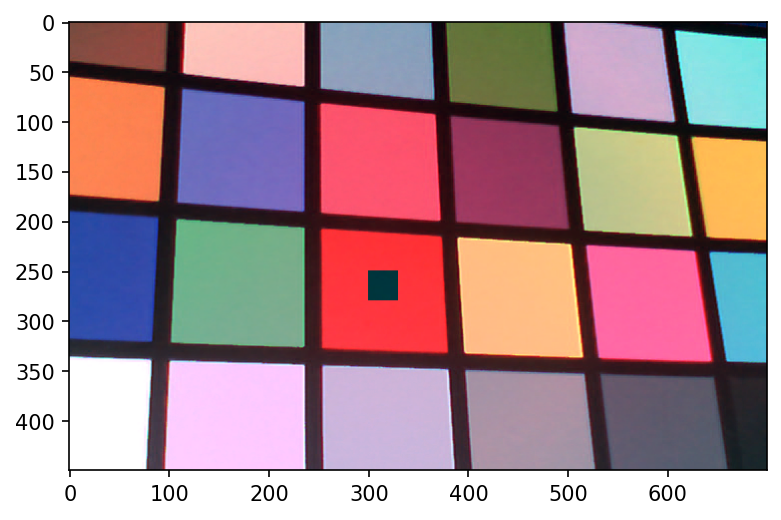

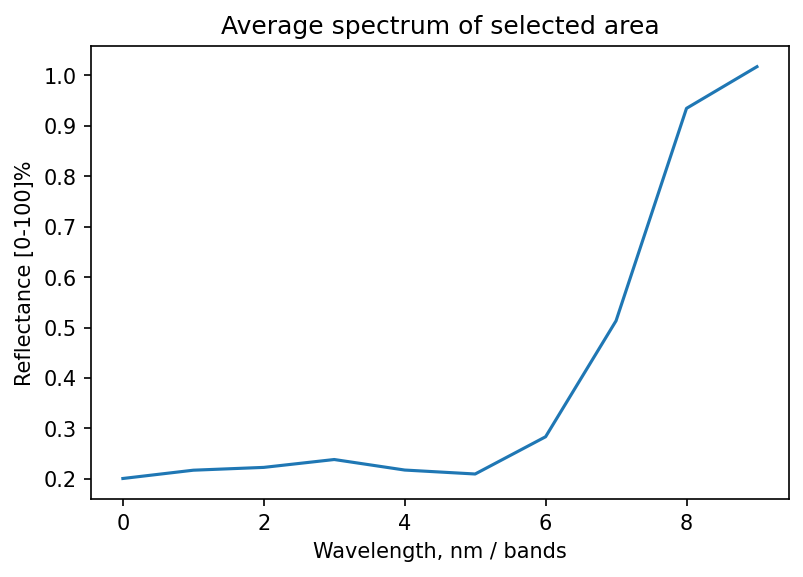

In [36]:
selection = get_region_spectra(corr_spectral_cube, object_RGB, 250, 300)

450 10 700
3
5
9
RGB:  (450, 700, 3)
cube:  (450, 10, 700)
small cube:  (450, 700, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.3469387
1.201375342723144
1.346938775510204


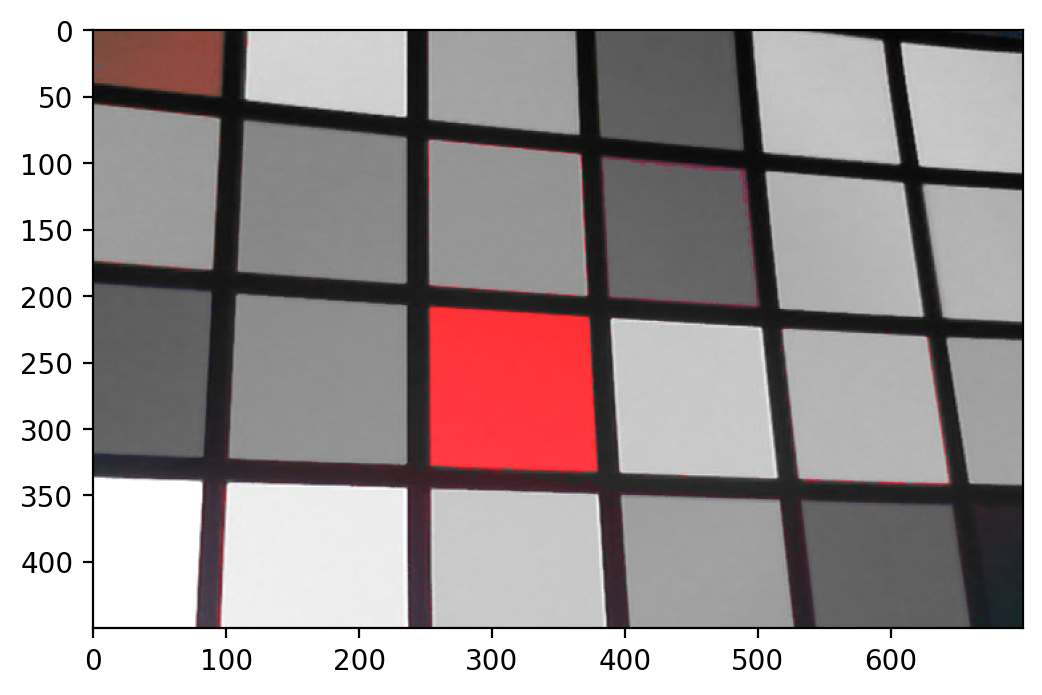

In [39]:
bands = [3, 5, 9]
segmentation(bands, 0.1, selection, corr_spectral_cube, object_RGB)